## Merge File

In [1]:
import csv
# Generate filenames programmatically
files = ["Result3/getXGBOOstTrainingData_{}.csv".format(i) for i in range(1000)]

merged_filename = "merged_result3.csv"

with open(merged_filename, 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    
    for index, filename in enumerate(files):
        with open(filename, 'r') as infile:
            reader = csv.reader(infile)
            
            # Skip header only if it's not the first file
            if index != 0:
                next(reader, None)
                
            # Write rows from current file to the output file
            writer.writerows(reader)


# Sort/Rank

In [2]:
import pandas as pd

# Read the merged CSV file into a DataFrame
df = pd.read_csv("merged_result3.csv")

# Sort the DataFrame by balance in descending order
df_sorted = df.sort_values(by='balance', ascending=False)

df_sorted.head(100)

,type,competitorID,time,exchange,odds,agentID,stake,distance,rank,balance,decision
1130739,Trade,4,23.927576,0,1.198327,53,15,269.824868,1,1.000136e+08,layer
1130741,Trade,4,23.989064,0,1.157053,53,15,278.916880,1,1.000136e+08,layer
1130711,Trade,4,23.276189,0,9.757154,53,15,269.824868,1,1.000136e+08,layer
1130713,Trade,4,23.290709,0,9.757154,53,15,269.824868,1,1.000136e+08,layer
1130717,Trade,4,23.371953,0,9.757154,53,15,269.824868,1,1.000136e+08,layer
...,...,...,...,...,...,...,...,...,...,...,...
1130817,Trade,4,25.554067,0,4.336821,53,15,291.119381,1,1.000136e+08,layer
1130821,Trade,4,25.603083,0,9.657110,53,15,291.119381,1,1.000136e+08,layer
1130825,Trade,4,25.718872,0,9.657118,53,15,291.119381,1,1.000136e+08,layer
1130851,Trade,4,26.475738,0,9.657154,53,15,302.378174,1,1.000136e+08,layer


## Top 20 %

In [3]:
# Calculate 20% of the total number of rows and retrieve the top rows
top_20_percent = int(0.20 * len(df_sorted))
top_20_df = df_sorted.head(top_20_percent)

# Save the top 20% rows to a new CSV file, if desired
top_20_df.to_csv("top_20_percent_3.csv", index=False)

## Prepare Data

In [19]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Import the data
data = pd.read_csv("top_20_percent_3.csv")
decision_counts = data['decision'].value_counts()
print(decision_counts)
# 2. Preprocessing

# Remove potentially irrelevant columns
data = data.drop(columns=["type", "competitorID", "exchange", "agentID","balance","odds"])

#Column that has left: time  odds  stake  distance  rank

# Convert 'decision' column to binary: 1 for 'backer' and 0 for 'layer'
data['decision'] = data['decision'].map({'backer': 1, 'layer': 0})

# Split data into training and testing sets
X = data.drop(columns="decision")
print(X.head())
y = data["decision"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


layer     369011
backer     80931
Name: decision, dtype: int64
        time  stake    distance  rank
0  23.927576     15  269.824868     1
1  23.989064     15  278.916880     1
2  23.276189     15  269.824868     1
3  23.290709     15  269.824868     1
4  23.371953     15  269.824868     1


## Training 

In [20]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
param_grid = {
    'eta': [0.01, 0.1, 0.3],  # Default: 0.3
    'max_depth': [4, 5, 6],       # Default: 6
    'subsample': [0.5, 0.75, 1.0],  # Default: 1
    'colsample_bytree': [0.5, 0.75, 1.0],  # Default: 1
    'gamma': [0, 0.1, 0.2]    # Default: 0
}
# Convert the booster to scikit-learn format
xgb_estimator = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=100
)
# Set up grid search
grid_search = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=2,
    verbose=2
)
# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best model for prediction and evaluation
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy (Best Model):", accuracy_best)
print(classification_report(y_test, y_pred_best))


Fitting 2 folds for each of 243 candidates, totalling 486 fits
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=1.0; total time=   7.9s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=1.0; total time=   7.9s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=0.75; total time=   8.7s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=0.75; total time=   8.6s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=0.5; total time=   8.9s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=4, subsample=0.5; total time=   9.1s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=5, subsample=0.5; total time=  10.6s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=5, subsample=0.5; total time=  10.7s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=5, subsample=0.75; total time=  10.4s
[CV] END colsample_bytree=0.5, eta=0.01, gamma=0, max_depth=5

Visulization

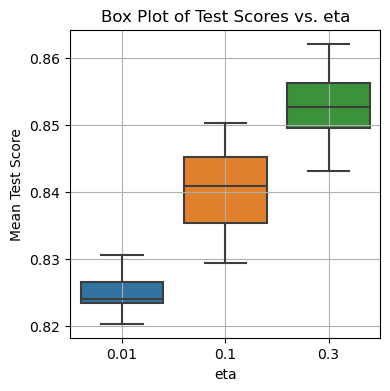

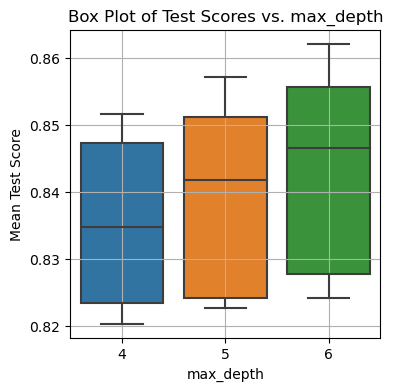

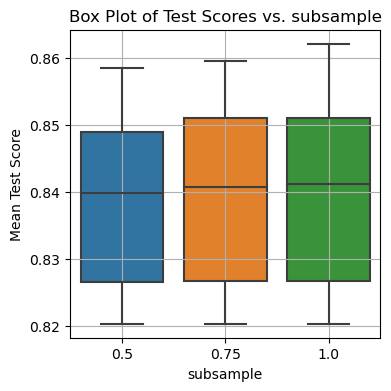

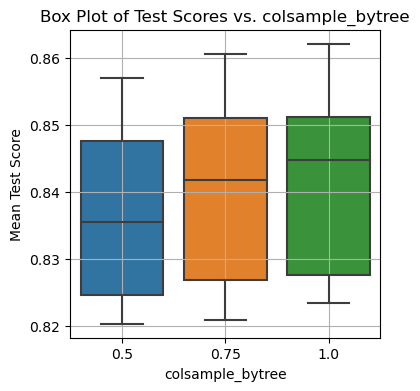

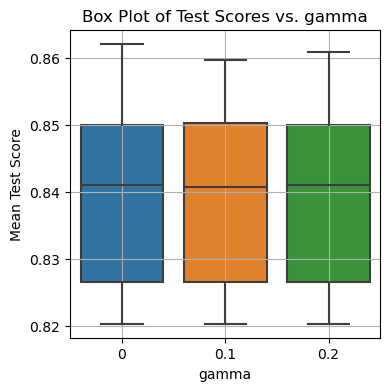

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the grid search results to a dataframe
results_df = pd.DataFrame(grid_search.cv_results_)

for param in param_grid.keys():
    plt.figure(figsize=(4,4))
    
    # Extract individual fold scores
    fold_scores = [results_df[f"split{i}_test_score"] for i in range(grid_search.cv)]
    fold_scores_df = pd.concat(fold_scores, axis=1)
    
    # Extract parameter values and add as a new column
    fold_scores_df[param] = results_df['param_' + param]
    
    # Melt the dataframe for seaborn
    melted_scores_df = fold_scores_df.melt(id_vars=param, 
                                           value_vars=[f"split{i}_test_score" for i in range(grid_search.cv)],
                                           var_name="cv_fold",
                                           value_name="score")

    # Boxplot
    sns.boxplot(data=melted_scores_df, x=param, y="score")
    plt.title(f'Box Plot of Test Scores vs. {param}')
    plt.ylabel('Mean Test Score')
    plt.grid(True)
    plt.show()


Accuracy: 0.8647056862505418

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92     73718
           1       0.88      0.29      0.44     16271

    accuracy                           0.86     89989
   macro avg       0.87      0.64      0.68     89989
weighted avg       0.87      0.86      0.84     89989



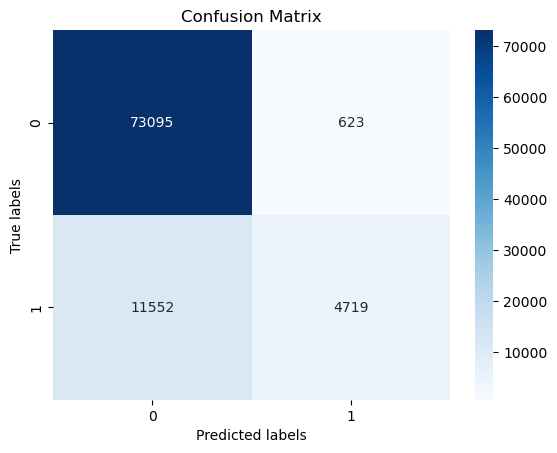

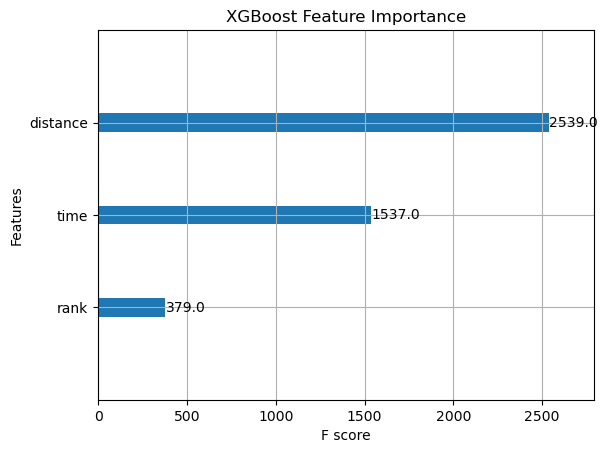

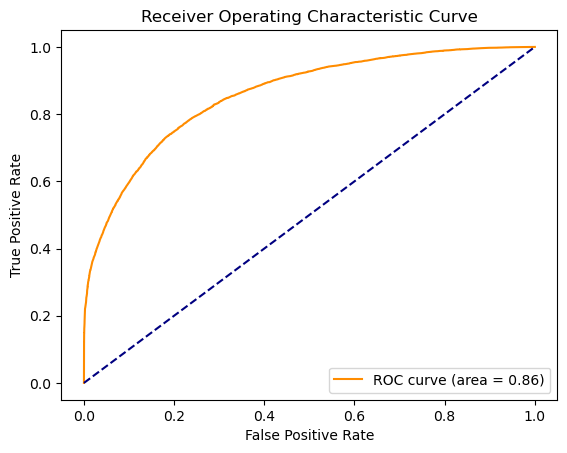

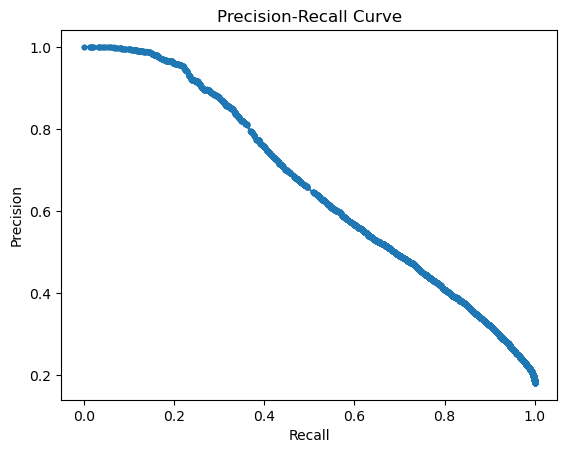

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns
import joblib

# 1. Testing on the Test Set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:,1]

# 2. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# 3. Visualization

# Feature Importance
xgb.plot_importance(best_model)
plt.title('XGBoost Feature Importance')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


## Save Model

In [23]:
# Save the best model to a .json file
best_model.get_booster().save_model('trained_xgboost_model.json')


<Figure size 2000x1500 with 0 Axes>

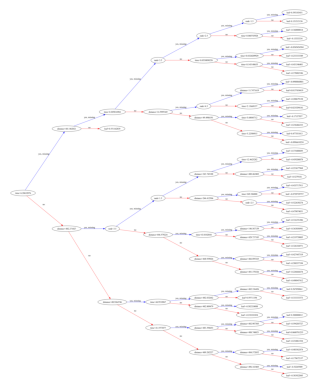

In [25]:
import matplotlib.pyplot as plt
# Plot first tree from the model
import os
os.environ["PATH"] += os.pathsep + '/opt/homebrew/bin'
# Plot the first tree
plt.figure(figsize=(20, 15))
xgb.plot_tree(best_model, num_trees=0, rankdir='LR')
plt.show()


{'colsample_bytree': 1.0, 'eta': 0.3, 'gamma': 0, 'max_depth': 6, 'subsample': 1.0}


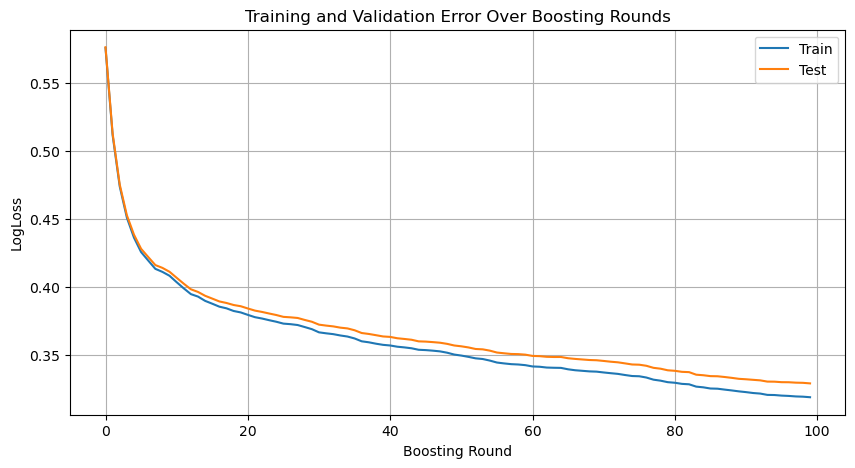

In [26]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Use the best parameters from the grid search
best_params = grid_search.best_params_
print(best_params)

# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    **best_params
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(X_train, y_train,eval_set=eval_set, verbose=False)

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results['validation_0']['logloss']
test_errors = results['validation_1']['logloss']

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Round')
plt.ylabel('LogLoss')
plt.title('Training and Validation Error Over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()


## N_estimator and early stopping

In [28]:
# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=1000, # Increasing n_estimators
    **best_params
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train, 
    y_train,
    eval_set=eval_set, 
    early_stopping_rounds=10, # Adding early stopping
    verbose=False
)

# Rest of your code remains unchanged


/Users/monny/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

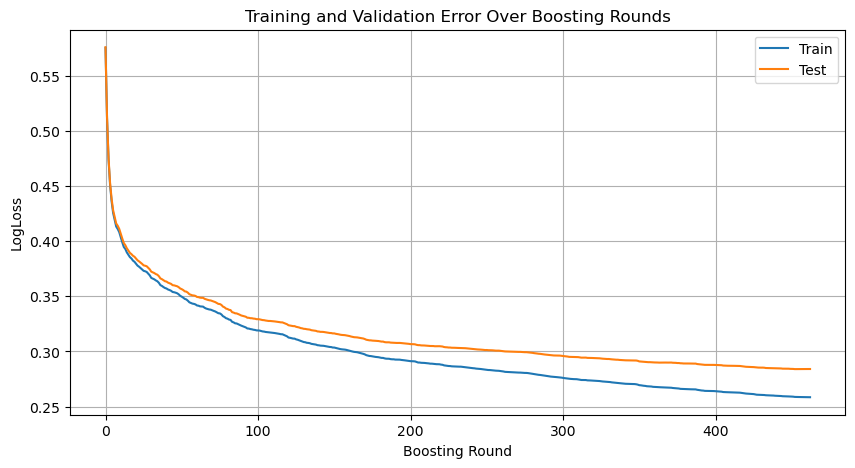

In [30]:
# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(X_train, y_train,eval_set=eval_set,early_stopping_rounds=10,verbose=False)

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results['validation_0']['logloss']
test_errors = results['validation_1']['logloss']

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Round')
plt.ylabel('LogLoss')
plt.title('Training and Validation Error Over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()


Best iteration: 452
Best ntree_limit: 453


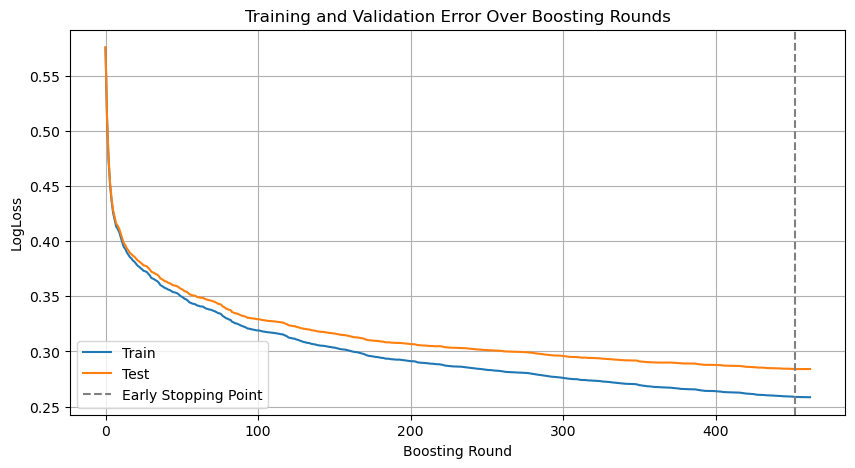

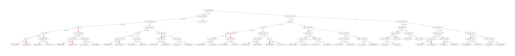

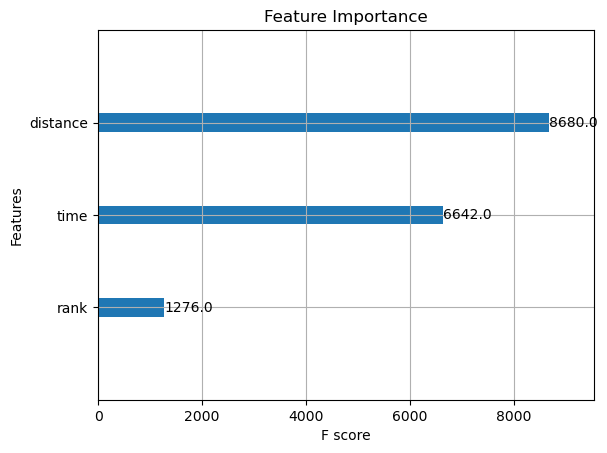

    Feature  Importance
2  distance    0.472648
3      rank    0.298600
0      time    0.228753
1     stake    0.000000


In [31]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=False)

# 1. Print the boosting round where early stopping occurred:
print(f"Best iteration: {best_xgb_estimator.get_booster().best_iteration}")
print(f"Best ntree_limit: {best_xgb_estimator.get_booster().best_ntree_limit}")

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results['validation_0']['logloss']
test_errors = results['validation_1']['logloss']

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.axvline(x=best_xgb_estimator.get_booster().best_iteration, color='gray', linestyle='--', label='Early Stopping Point')
plt.xlabel('Boosting Round')
plt.ylabel('LogLoss')
plt.title('Training and Validation Error Over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()

# 2. Visualize the model using XGBoost's plot functionalities:

# a. Plotting the first tree:
xgb.plot_tree(best_xgb_estimator, num_trees=0)
plt.show()

# b. Displaying the importance of each feature:
xgb.plot_importance(best_xgb_estimator)
plt.title('Feature Importance')
plt.show()

# If you'd like a table of feature importances:
importances = best_xgb_estimator.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)


              precision    recall  f1-score   support

           0       0.88      0.98      0.93     73718
           1       0.85      0.41      0.56     16271

    accuracy                           0.88     89989
   macro avg       0.87      0.70      0.74     89989
weighted avg       0.88      0.88      0.86     89989

[[72521  1197]
 [ 9541  6730]]


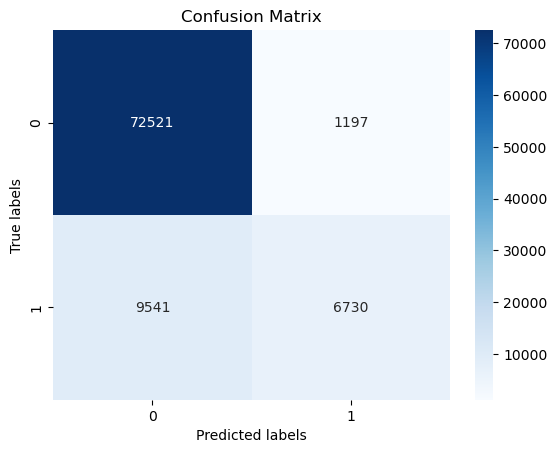

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Predict the classes
y_pred = best_xgb_estimator.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Visualizing the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [35]:
print(best_xgb_estimator.best_ntree_limit)


453


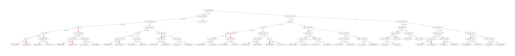

In [46]:
xgb.plot_tree(best_xgb_estimator, num_trees=0, max_depth=4)
plt.show()


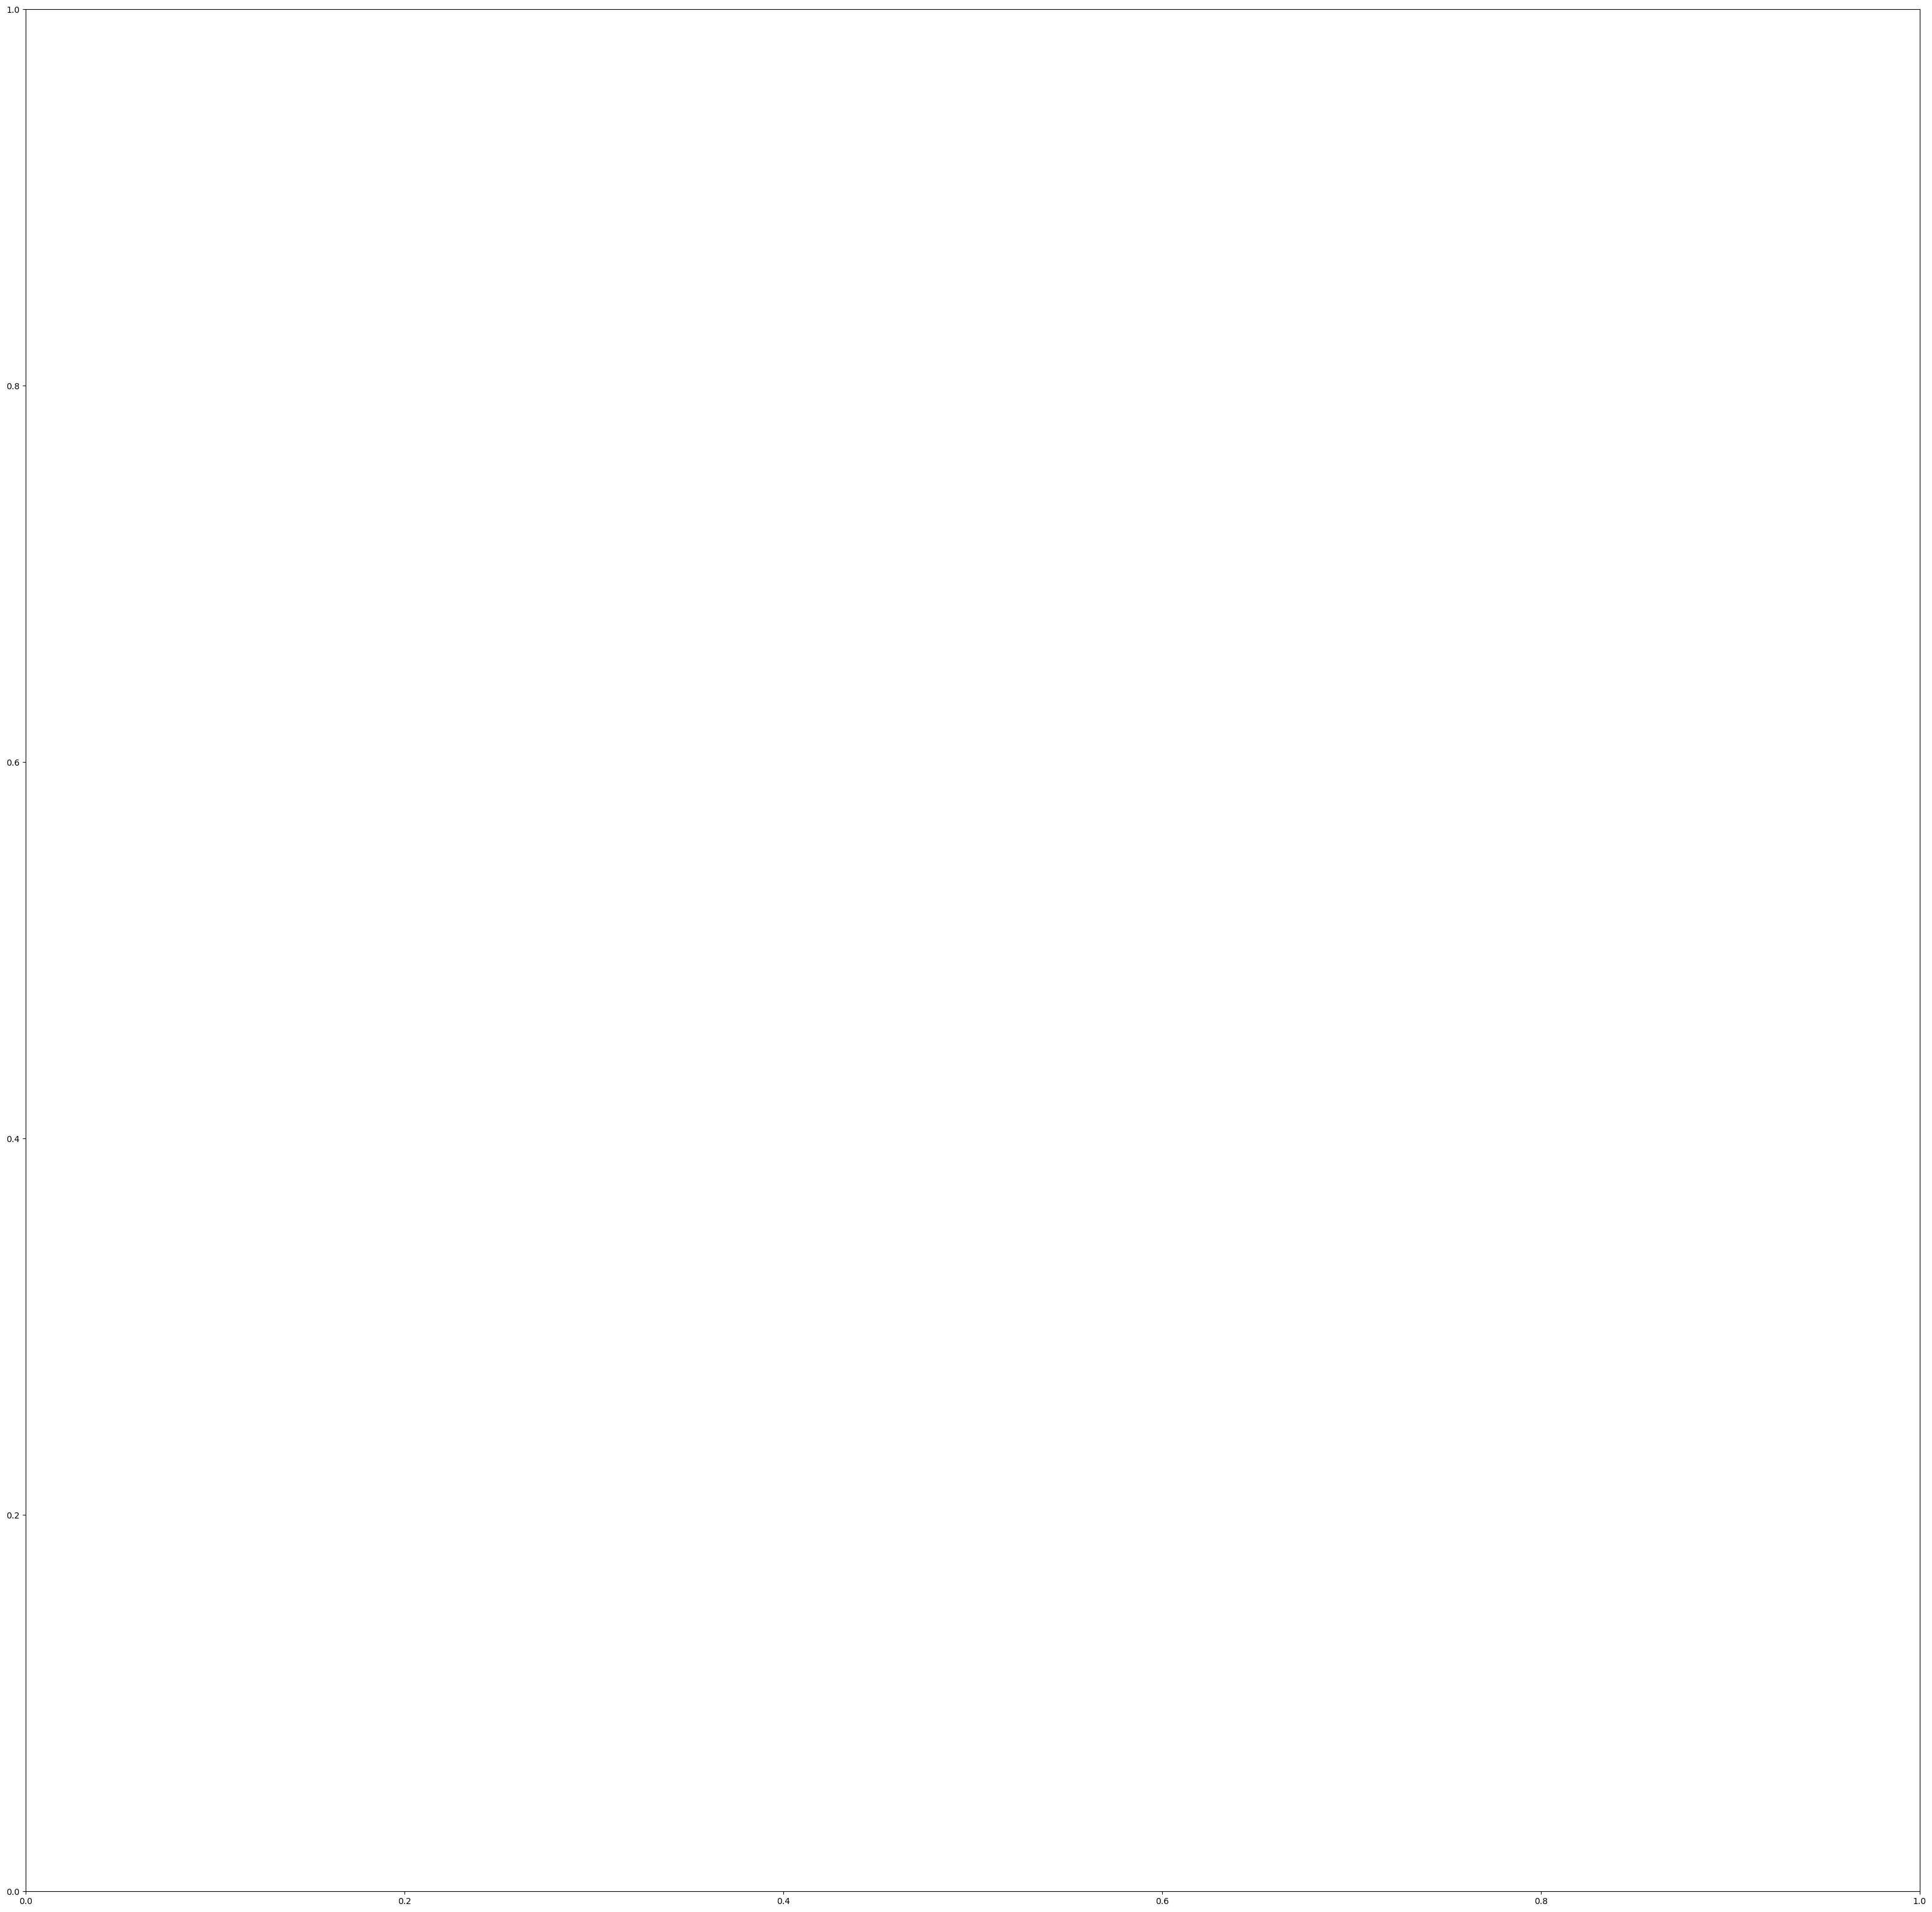

In [50]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Define figure size and resolution
fig, ax = plt.subplots(figsize=(40, 40))

# Plotting the tree with the max_depth option
xgb.plot_tree(best_xgb_estimator, num_trees=0, rankdir='LR')

# Saving the plot with increased resolution
plt.savefig("xgboost_tree.png", dpi=600)
plt.close()

In [51]:


# Get the booster object
booster = best_xgb_estimator.get_booster()

# Dump the first tree as text
tree_as_text = booster.get_dump()[0]

print(tree_as_text)

0:[time<6.20632076] yes=1,no=2,missing=1
	1:[distance<60.1462021] yes=3,no=4,missing=3
		3:[time<0.205816984] yes=7,no=8,missing=7
			7:[rank<4] yes=13,no=14,missing=13
				13:[rank<3] yes=25,no=26,missing=25
					25:[rank<2] yes=49,no=50,missing=49
						49:leaf=0.393103451
						50:leaf=0.151515156
					26:[time<0.060743928] yes=51,no=52,missing=51
						51:leaf=-0.360000014
						52:leaf=-0.13333334
				14:[time<0.0530890226] yes=27,no=28,missing=27
					27:[time<0.0324209929] yes=53,no=54,missing=53
						53:leaf=-0.0545454584
						54:leaf=-0.233333349
					28:[time<0.145148635] yes=55,no=56,missing=55
						55:leaf=-0.451546401
						56:leaf=-0.378082186
			8:[distance<14.5995369] yes=15,no=16,missing=15
				15:[rank<5] yes=29,no=30,missing=29
					29:[distance<11.7471619] yes=57,no=58,missing=57
						57:leaf=-0.0988860801
						58:leaf=0.0157434419
					30:[time<2.13669157] yes=59,no=60,missing=59
						59:leaf=-0.200679138
						60:leaf=0.0235294141
				16:[distance<49.4986191